In [89]:
import json
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from interpolation import interpolate_mmx, create_patterns
from constants import mmcc_forecast_columns 
from converters import convert_rp5_to_mmx, convert_raw_to_mmx, convert_mmx_to_mmcc_forecast, convert_raw_to_mmx, \
                convert_mmx_to_mmcc_rwis
from loaders import load_rp5_stations, load_mm94_stations
from geographical import find_nearest_wmo_station
from mmcc_input import get_station_config, get_road_config, get_rwis_data_json, get_global_forecast_json

## Choose MM94 station

In [90]:
mm94_station_id = 113

raw = load_mm94_stations(mm94_station_id)
mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, 20)
mmx_rwis_interpolated = create_patterns(mmx_rwis_interpolated)
mmcc_rwis = convert_mmx_to_mmcc_rwis(mmx_rwis_interpolated)
mmcc_rwis = mmcc_rwis.set_index("date_time_utc")

In [91]:
wmo_station_id = find_nearest_wmo_station(mm94_station_id)

rp5 = load_rp5_stations(wmo_station_id)
mmx_forecast = convert_rp5_to_mmx(rp5)
mmx_forecast_interpolated = interpolate_mmx(mmx_forecast, 20)
mmcc_forecast = convert_mmx_to_mmcc_forecast(mmx_forecast_interpolated)
mmcc_forecast = mmcc_forecast.set_index("date_time_utc")
#mmcc_forecast.humidity = mmcc_forecast.humidity.replace({9999: 0})
#mmcc_forecast.pressure = mmcc_forecast.pressure.replace({9999: 0})
#mmcc_forecast.wind_direction = mmcc_forecast.wind_direction.replace({9999: 0})
#mmcc_forecast.wind_speed = mmcc_forecast.wind_speed.replace({9999: 0})
mmcc_forecast = mmcc_forecast.replace({9999: 0})

41.5107202528


## Get station configuration

In [92]:
import requests
from time import sleep
import simplejson

station_config = get_station_config(mm94_station_id)
road_config = get_road_config(mm94_station_id)

url = 'http://127.0.0.1:5000'
url_roadcast = url + '/roadcast'
url_calc = url + '/calculation'

i = 0
for time_record in mmcc_rwis_part.index:
    rwis_data_json = get_rwis_data_json(mmcc_rwis, time_record)
    global_forecast_json = get_global_forecast_json(mmcc_forecast, time_record)
    data = {"station_config": station_config, 
              "road_config": road_config,
              "global_forecast": global_forecast_json,
              "rwis_data": rwis_data_json}
    
    for k, v in data['global_forecast'].items():
        data['global_forecast'][k]['cloudiness'] = int(data['global_forecast'][k]['cloudiness'])
        data['global_forecast'][k]['precipitation_intensity'] = 0
    
    with open('/mnt/HARD/MinMax94/data/json_test/' + str(i) + '.txt', "w") as file:
        simplejson.dump(data, file, indent=2, ignore_nan=True)
    
    i+=1
    
    with requests.Session() as session:
        session.headers = {'Content-type': 'application/json', 'Host': ".api.mmcc.pkcup.ru", 
                           'cache-control': "no-cache", #'postman-token': '727b926f-c7b5-854e-06d7-bea9df150a12', 
                           'User-Agent':'test'}

        response = session.post(url_calc, params={"key":"MeAuthKeyMeSmart"}, json=data)
        sleep(2) ## What should I do with it
        #print(response.url)
        job_id = json.loads(response.text)['job_id']
        response = session.get(url_roadcast, params={"job_id": job_id, "key": "MeAuthKeyMeSmart"}, timeout=5)
        print(i, response.url)
        z = response.content

1 http://127.0.0.1:5000/roadcast?job_id=5a71ee9af46c16000cc04b9d&key=MeAuthKeyMeSmart
2 http://127.0.0.1:5000/roadcast?job_id=5a71ee9cf46c16001321327a&key=MeAuthKeyMeSmart
3 http://127.0.0.1:5000/roadcast?job_id=5a71ee9ef46c16000cc04b9e&key=MeAuthKeyMeSmart
4 http://127.0.0.1:5000/roadcast?job_id=5a71eea1f46c16000a45f7b1&key=MeAuthKeyMeSmart
5 http://127.0.0.1:5000/roadcast?job_id=5a71eea3f46c16000ed4e9dd&key=MeAuthKeyMeSmart
6 http://127.0.0.1:5000/roadcast?job_id=5a71eea5f46c1600147b1668&key=MeAuthKeyMeSmart
7 http://127.0.0.1:5000/roadcast?job_id=5a71eea7f46c160016645cd3&key=MeAuthKeyMeSmart
8 http://127.0.0.1:5000/roadcast?job_id=5a71eea9f46c16000a45f7b2&key=MeAuthKeyMeSmart
9 http://127.0.0.1:5000/roadcast?job_id=5a71eeabf46c160008bd85e8&key=MeAuthKeyMeSmart
10 http://127.0.0.1:5000/roadcast?job_id=5a71eeadf46c16000dadb2a7&key=MeAuthKeyMeSmart


In [93]:
mmcc_rwis_part.t_road

date_time_utc
2015-12-01 12:00:00   -2.9
2015-12-01 12:20:00   -2.9
2015-12-01 12:40:00   -2.9
2015-12-01 13:00:00   -2.9
2015-12-01 13:20:00   -2.9
2015-12-01 13:40:00   -2.9
2015-12-01 14:00:00   -2.9
2015-12-01 14:20:00   -2.9
2015-12-01 14:40:00   -2.9
2015-12-01 15:00:00   -2.7
Name: t_road, dtype: float64

In [94]:
mmcc_forecast_part.t_air

date_time_utc
2015-12-01 12:00:00   -5.1
2015-12-01 12:20:00   -5.1
2015-12-01 12:40:00   -5.1
2015-12-01 13:00:00   -5.1
2015-12-01 13:20:00   -5.1
2015-12-01 13:40:00   -5.0
2015-12-01 14:00:00   -5.0
2015-12-01 14:20:00   -5.0
2015-12-01 14:40:00   -5.0
2015-12-01 15:00:00   -5.0
Name: t_air, dtype: float64

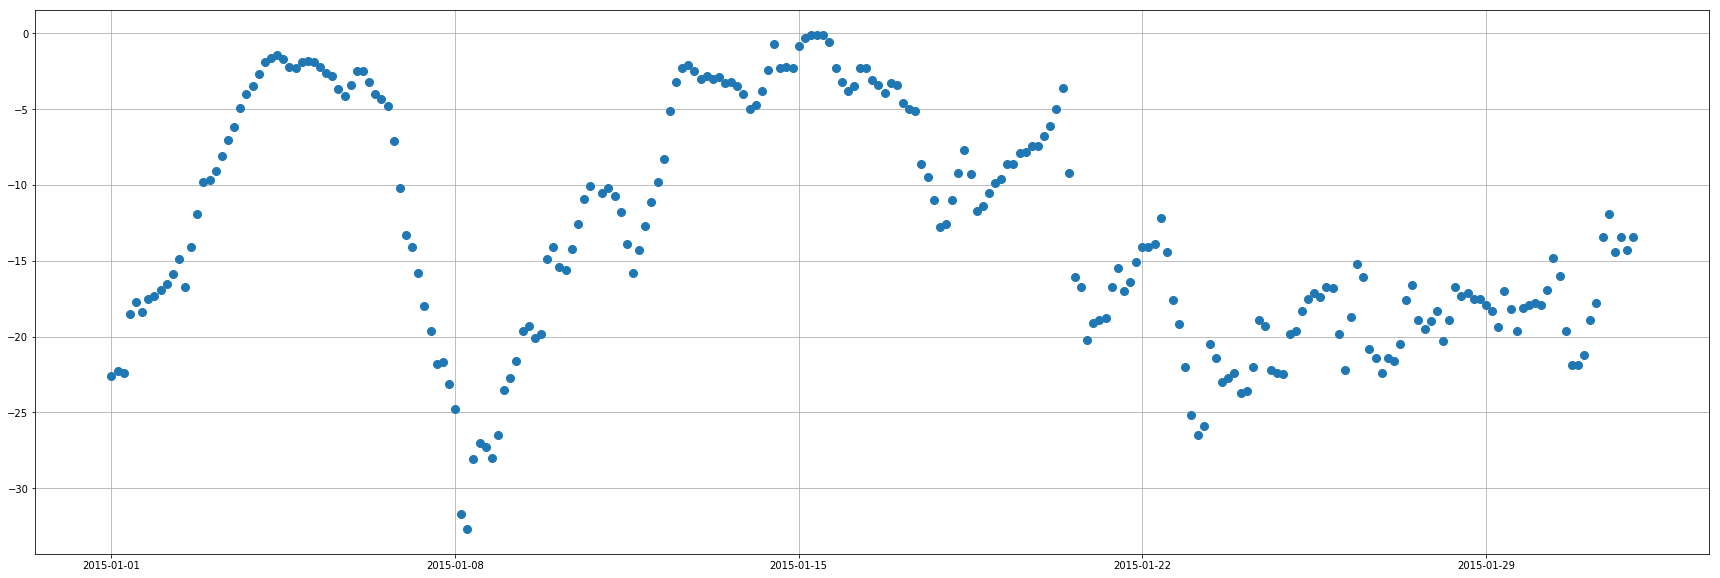

In [74]:
import matplotlib.pyplot as plt

df = copy(mmx_forecast)
start = pd.Timestamp(2015, 1, 1)
end = pd.Timestamp(2015, 2, 1)

plot_df = df[(df.date_time_utc <= end) & (df.date_time_utc >= start)]
plt.figure(figsize=(30, 10))
plt.plot_date(plot_df.date_time_utc, plot_df.data_t_air, markersize=8)
plt.grid(which='both')
plt.show()

In [75]:
start = pd.Timestamp(2015, 12, 1, 12)
end = pd.Timestamp(2015, 12, 1, 15)

mmcc_rwis_part = mmcc_rwis[(mmcc_rwis.index >= start) & (mmcc_rwis.index <= end)]
mmcc_forecast_part = mmcc_forecast[(mmcc_forecast.index >= start) & (mmcc_forecast.index <= end)]

## Get road configuration

In [12]:
road_config = get_road_config(mm94_station_id)

## Get RWIS data 

In [13]:
rwis_data_json = get_rwis_data_json(mmcc_rwis, pd.Timestamp(2015, 12, 30, 13, 0, 0))
#rwis_data_json

## Get global forecast

In [14]:
global_forecast_json = get_global_forecast_json(mmcc_forecast, pd.Timestamp(2015, 12, 30, 13, 0, 0))
global_forecast_json

{'2015-12-30 10:00 UTC': {'cloudiness': 50.0,
  'humidity': 34.0,
  'p_weather': 0.0,
  'precipitation_intensity': 9999.0,
  'precipitation_type': 0.0,
  'pressure': 762.79999999999995,
  't_air': 16.800000000000001,
  't_dew_point': 0.80000000000000004,
  'visibility': 4000.0,
  'wind_direction': 247.5,
  'wind_speed': 1.7},
 '2015-12-30 11:00 UTC': {'cloudiness': 60.0,
  'humidity': 35.0,
  'p_weather': 0.0,
  'precipitation_intensity': 9999.0,
  'precipitation_type': 0.0,
  'pressure': 761.89999999999998,
  't_air': 17.100000000000001,
  't_dew_point': 1.5,
  'visibility': 4000.0,
  'wind_direction': 270.0,
  'wind_speed': 1.3},
 '2015-12-30 12:00 UTC': {'cloudiness': 80.0,
  'humidity': 36.0,
  'p_weather': 0.0,
  'precipitation_intensity': 9999.0,
  'precipitation_type': 0.0,
  'pressure': 761.10000000000002,
  't_air': 17.300000000000001,
  't_dew_point': 2.1000000000000001,
  'visibility': 4000.0,
  'wind_direction': 292.5,
  'wind_speed': 1.0},
 '2015-12-30 13:00 UTC': {'cloudi